In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "svm"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # 결정 경계에서 w0*x0 + w1*x1 + b = 0 이므로
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

# 5.1 선형 SVM분류

In [3]:
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# SVM 분류 모델
svm_clf = SVC(kernel="linear", C=float("inf"))
svm_clf.fit(X, y)


SVC(C=inf, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

## 5.1.1 소프트 마진 분류

In [4]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X= iris['data'][:,(2,3)]
y= (iris['target']==2).astype(np.float64)

svm_clf = Pipeline([
    ("scaler",StandardScaler()),
    ("linear_svc",LinearSVC(C=1,loss="hinge",random_state=42))
])

svm_clf.fit(X,y)


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linear_svc',
                 LinearSVC(C=1, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=42, tol=0.0001,
                           verbose=0))],
         verbose=False)

In [5]:
svm_clf.predict([[5.5,1.7]])

array([1.])

#### 규제 설정을 비교하는 그래프

In [6]:
scaler =  StandardScaler()
svm_clf1 =LinearSVC(C=1,loss="hinge",random_state=42)
svm_clf2 =LinearSVC(C=100,loss="hinge",random_state=42)

scaled_svm_clf1 = Pipeline([
    ("scaler",scaler),
    ("linear_svc",svm_clf1)
])

scaled_svm_clf2 = Pipeline([
    ("scaler",scaler),
    ("linear_svc",svm_clf2)
])

scaled_svm_clf1.fit(X,y)
scaled_svm_clf2.fit(X,y)



/opt/anaconda3/envs/env/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linear_svc',
                 LinearSVC(C=100, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=42, tol=0.0001,
                           verbose=0))],
         verbose=False)

In [7]:
# 스케일되지 않은 파라미터로 변경
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# 서포트 벡터 찾기 (libsvm과 달리 liblinear 라이브러리에서 제공하지 않기 때문에 
# LinearSVC에는 서포트 벡터가 저장되어 있지 않습니다.)
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

그림 저장: regularization_plot


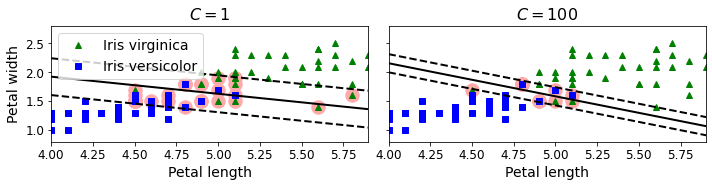

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 5.9)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

plt.sca(axes[1])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 5.99)
plt.xlabel("Petal length", fontsize=14)
plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

save_fig("regularization_plot")

# 5.2 비선형 SVM 분류

#### 방법1 : 다항특성 추가

그림 저장: higher_dimensions_plot


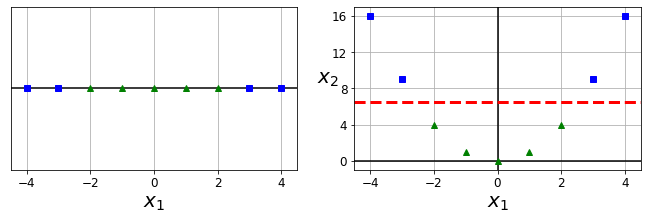

In [9]:
X1D = np.linspace(-4,4,9).reshape(-1,1)
X2D = np.c_[X1D,X1D**2]
y=np.array([0,0,1,1,1,1,1,0,0])
plt.figure(figsize=(10,3))

plt.subplot(121)
plt.grid(True,which='both')
plt.axhline(y=0, color='k')
plt.plot(X1D[:,0][y==0], np.zeros(4) , "bs")
plt.plot(X1D[:,0][y==1], np.zeros(5), "g^")
plt.gca().get_yaxis().set_ticks([])
plt.xlabel(r"$x_1$", fontsize= 20)
plt.axis([-4.5,4.5,-0.2,0.2])

plt.subplot(122)
plt.grid(True,which="both")
plt.axhline(y=0,color="k")
plt.axvline(x=0,color="k")
plt.plot(X2D[:,0][y==0], X2D[:,1][y==0], "bs")
plt.plot(X2D[:,0][y==1], X2D[:,1][y==1], " g^")
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
plt.gca().get_yaxis().set_ticks([0,4,8,12,16])
plt.plot([-4.5,4.5],[6.5,6.5],"r--",linewidth=3)
plt.axis([-4.5,4.5,-1,17])

plt.subplots_adjust(right=1)

save_fig("higher_dimensions_plot", tight_layout=False)
plt.show()

#선형적으로는 구분 안되던 것이(좌)
#다항 특성을 추가하면 선형적으로 분류될수 있음(우)

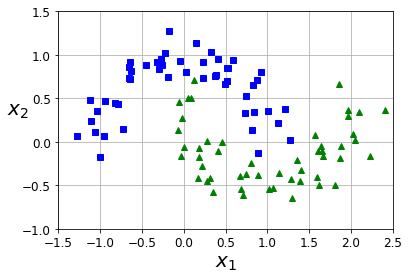

In [10]:
#두개의 반달모양 데이터셋 생성

from sklearn.datasets import make_moons
X,y = make_moons(n_samples=100,noise=0.15,random_state=42)


def plot_dataset(X,y,axes):
    plt.plot(X[:,0][y==0], X[:,1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True,which="both")
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$",fontsize=20,rotation=0)
    
plot_dataset(X,y,[-1.5,2.5,-1,1.5])
plt.show()

In [11]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline([
    ("poly_features", PolynomialFeatures(degree=3)),
    ("scaler",StandardScaler()),
    ("svm_clf",LinearSVC(C=10,loss="hinge", random_state=42))
])

polynomial_svm_clf.fit(X,y)



Pipeline(memory=None,
         steps=[('poly_features',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 LinearSVC(C=10, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=42, tol=0.0001,
                           verbose=0))],
         verbose=False)

그림 저장: moons_polynomial_svc_plot


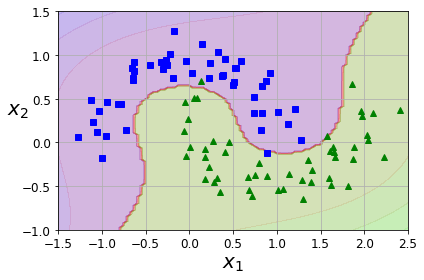

In [12]:
def plot_predictions(clf,axes):
    x0s = np.linspace(axes[0],axes[1],100)
    x1s = np.linspace(axes[2],axes[3],100)
    x0, x1 =np.meshgrid(x0s,x1s)
    X=np.c_[x0.ravel(),x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0,x1,y_pred, cmap = plt.cm.brg, alpha = 0.2)
    plt.contourf(x0,x1,y_decision, cmap=plt.cm.brg,alpha=0.1)
    
    
plot_predictions(polynomial_svm_clf,[-1.5,2.5,-1,1.5])
plot_dataset(X,y,[-1.5,2.5,-1,1.5])

save_fig("moons_polynomial_svc_plot")
plt.show()

## 5.2.1 다항식 커널

In [13]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly",degree=3,coef0=1,C=5))

])

poly_kernel_svm_clf.fit(X,y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=5, break_ties=False, cache_size=200, class_weight=None,
                     coef0=1, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='poly', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [14]:
poly100_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf",SVC(kernel="poly",degree=10,coef0=100,C=5)) #coef0 가 r값
])

poly100_kernel_svm_clf.fit(X,y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=5, break_ties=False, cache_size=200, class_weight=None,
                     coef0=100, decision_function_shape='ovr', degree=10,
                     gamma='scale', kernel='poly', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

그림 저장: moons_kernelized_polynomial_svc_plot


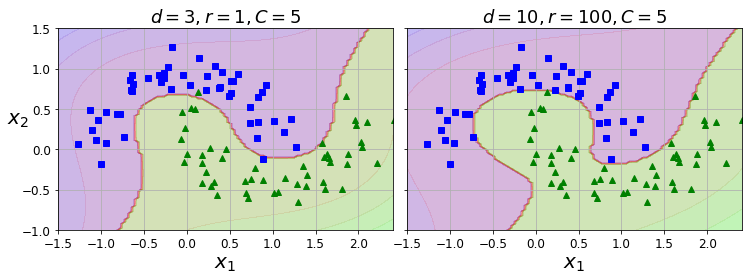

In [15]:
fig, axes = plt.subplots(ncols=2, figsize=(10.5,4), sharey=True)

plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5,2.45,-1,1.5])
plot_dataset(X,y,[-1.5,2.4,-1,1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

plt.sca(axes[1])
plot_predictions(poly100_kernel_svm_clf, [-1.5,2.45,-1,1.5])
plot_dataset(X,y,[-1.5,2.4,-1,1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)
plt.ylabel("")

save_fig("moons_kernelized_polynomial_svc_plot")
plt.show()


# r은 고차항의 영향을 줄여줌
# 10차원으로 늘렸지만 r값(coef0 파라미터)도 늘려줘서 덜 과적합된듯?

## 5.2.2 유사도 특성

#### 식 5-1: 가우시안 RBF

$
{\displaystyle \phi_{\gamma}(\mathbf{x}, \boldsymbol{\ell})} = {\displaystyle \exp({\displaystyle -\gamma \left\| \mathbf{x} - \boldsymbol{\ell} \right\|^2})}
$

In [16]:
#특정 랜드마크와 닮았는지 측정하여 새로운 특성을 만드는 방법

#그중 하나가 가우시안 RBF를 유사도 함수로

그림 저장: kernel_method_plot


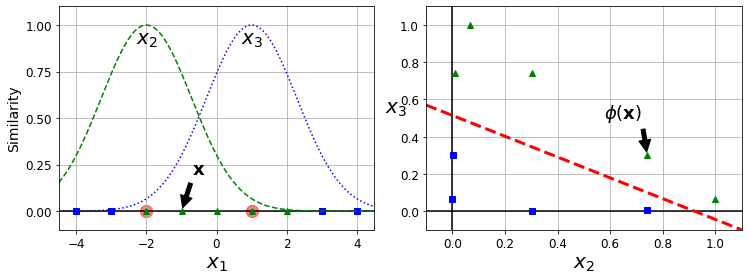

In [17]:
def gaussian_rbf(x,landmark,gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

gamma =0.3

x1s = np.linspace(-4.5,4.5,200).reshape(-1,1)
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)

#(-2,1)를 랜드마크로 가우시안rbf 유사도 계산하여 특성생성

XK = np.c_[gaussian_rbf(X1D, -2 , gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10.5,4))

plt.subplot(121)
plt.grid(True, which="both")
plt.axhline(y=0, color='k')
plt.scatter(x=[-2,1],y=[0,0], s=150, alpha = 0.5, c = "red")
plt.plot(X1D[:,0][yk==0],np.zeros(4),"bs") #1차원특성
plt.plot(X1D[:,0][yk==1],np.zeros(5),"g^")
plt.plot(x1s,x2s,"g--")
plt.plot(x1s,x3s,"b:")
plt.gca().get_yaxis().set_ticks([0,0.25,0.5,0.75,1])
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"Similarity", fontsize=14)
plt.annotate(r'$\mathbf{x}$',
             xy=(X1D[3, 0], 0), #가르킬위치(점)
             xytext=(-0.5, 0.20), # 텍스트위치
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )

plt.text(-2,0.9, "$x_2$", ha = "center", fontsize= 20)
plt.text(1,0.9,"$x_3$", ha = "center", fontsize=20)
plt.axis([-4.5,4.5,-0.1,1.1])

plt.subplot(122)
plt.grid(True,which="both")
plt.axhline(y=0,color="k")
plt.axvline(x=0,color="k")
plt.plot(XK[:,0][yk==0],XK[:,1][yk==0], "bs") #유사도특성
plt.plot(XK[:,0][yk==1],XK[:,1][yk==1], "g^")

plt.xlabel(r"$x_2$", fontsize=20)
plt.ylabel(r"$x_3$", fontsize=20, rotation=0)
plt.annotate(r'$\phi\left(\mathbf{x}\right)$',
              xy=(XK[3,0],XK[3,1]), #(특성1,특성2) 가르킬 점
              xytext =(0.65,0.50),
            ha="center",
            arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
              
              )

plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1])
    
plt.subplots_adjust(right=1)

save_fig("kernel_method_plot")
plt.show()

## 5.2.3 가우시안 RBF커널

그림 저장: moons_rbf_svc_plot


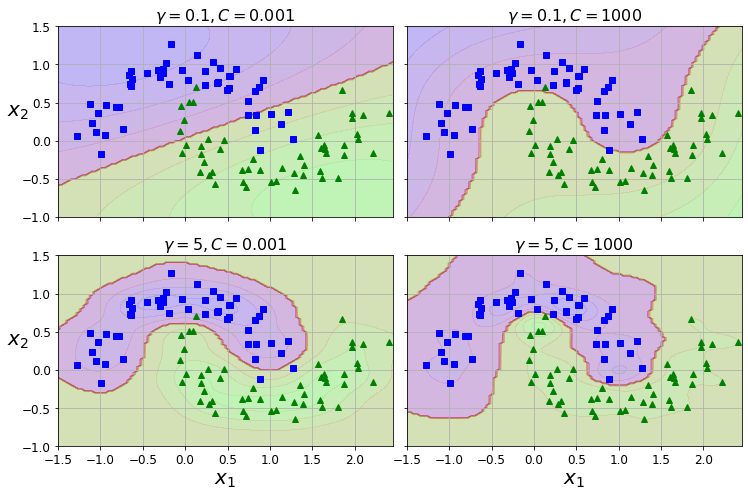

In [18]:
from sklearn.svm import SVC

gamma1,gamma2 = 0.1,5
C1,C2 = 0.001,1000

hyperparams = (gamma1,C1),(gamma1,C2),(gamma2,C1),(gamma2,C2)

svm_clfs=[]
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
        ("scaler",StandardScaler()),
        ("svm_clf",SVC(kernel="rbf", gamma=gamma , C=C))        
    ])
    rbf_kernel_svm_clf.fit(X,y)
    svm_clfs.append(rbf_kernel_svm_clf)
    

fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(10.5,7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i//2, i% 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma,C= hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma,C), fontsize=16)
    
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")
    

save_fig("moons_rbf_svc_plot")
plt.show()

# 5.3 SVM 회귀

#### 선형 회귀

In [19]:
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

In [20]:
from sklearn.svm import LinearSVR
svm_reg = LinearSVR(epsilon=1.5)
svm_reg.fit(X,y)

LinearSVR(C=1.0, dual=True, epsilon=1.5, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=None, tol=0.0001, verbose=0)

In [21]:
svm_reg1 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42)
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)

def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg1.predict([[eps_x1]])

그림 저장: svm_regression_plot


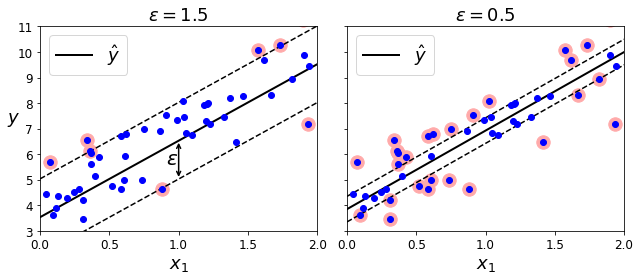

In [22]:
def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_reg1, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
#plt.plot([eps_x1, eps_x1], [eps_y_pred, eps_y_pred - svm_reg1.epsilon], "k-", linewidth=2)
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg1.epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20)
plt.sca(axes[1])
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon), fontsize=18)
save_fig("svm_regression_plot")
plt.show()

#### 비선형회귀 - 커널이용

In [23]:
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

In [24]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg.fit(X, y)

SVR(C=100, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [25]:
from sklearn.svm import SVR

svm_poly_reg1 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg2 = SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1, gamma="scale")
svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y)


SVR(C=0.01, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

그림 저장: svm_with_polynomial_kernel_plot


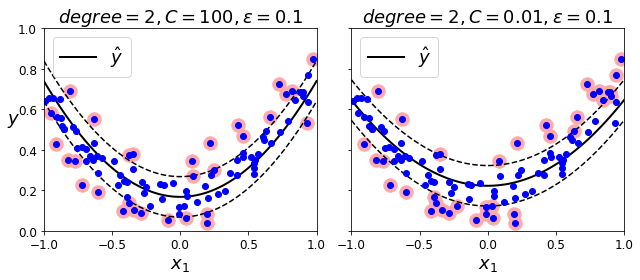

In [26]:
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg1.degree, svm_poly_reg1.C, svm_poly_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
plt.sca(axes[1])
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg2.degree, svm_poly_reg2.C, svm_poly_reg2.epsilon), fontsize=18)
save_fig("svm_with_polynomial_kernel_plot")
plt.show()

# 5.4 SVM 이론

In [27]:
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = (iris["target"] == 2).astype(np.float64)  # Iris virginica

In [28]:
#### 결정함수 h평면(초평면, hyperplane)과 특성평면의 교선이 결정경계

그림 저장: iris_3D_plot


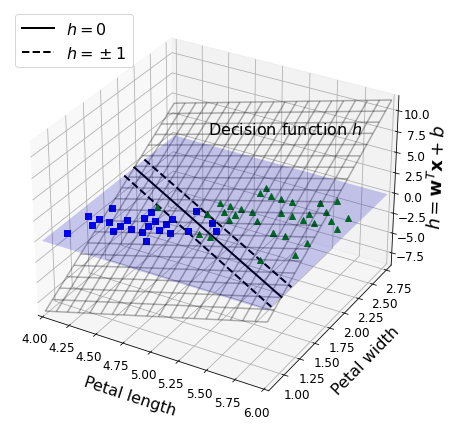

In [29]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3D_decision_function(ax, w, b, x1_lim=[4, 6], x2_lim=[0.8, 2.8]):
    x1_in_bounds = (X[:, 0] > x1_lim[0]) & (X[:, 0] < x1_lim[1])
    X_crop = X[x1_in_bounds]
    y_crop = y[x1_in_bounds]
    x1s = np.linspace(x1_lim[0], x1_lim[1], 20)
    x2s = np.linspace(x2_lim[0], x2_lim[1], 20)
    x1, x2 = np.meshgrid(x1s, x2s)
    xs = np.c_[x1.ravel(), x2.ravel()]
    df = (xs.dot(w) + b).reshape(x1.shape)
    m = 1 / np.linalg.norm(w)
    boundary_x2s = -x1s*(w[0]/w[1])-b/w[1]
    margin_x2s_1 = -x1s*(w[0]/w[1])-(b-1)/w[1]
    margin_x2s_2 = -x1s*(w[0]/w[1])-(b+1)/w[1]
    ax.plot_surface(x1s, x2, np.zeros_like(x1),
                    color="b", alpha=0.2, cstride=100, rstride=100)
    ax.plot(x1s, boundary_x2s, 0, "k-", linewidth=2, label=r"$h=0$")
    ax.plot(x1s, margin_x2s_1, 0, "k--", linewidth=2, label=r"$h=\pm 1$")
    ax.plot(x1s, margin_x2s_2, 0, "k--", linewidth=2)
    ax.plot(X_crop[:, 0][y_crop==1], X_crop[:, 1][y_crop==1], 0, "g^")
    ax.plot_wireframe(x1, x2, df, alpha=0.3, color="k")
    ax.plot(X_crop[:, 0][y_crop==0], X_crop[:, 1][y_crop==0], 0, "bs")
    ax.axis(x1_lim + x2_lim)
    ax.text(4.5, 2.5, 3.8, "Decision function $h$", fontsize=16)
    ax.set_xlabel(r"Petal length", fontsize=16, labelpad=10)
    ax.set_ylabel(r"Petal width", fontsize=16, labelpad=10)
    ax.set_zlabel(r"$h = \mathbf{w}^T \mathbf{x} + b$", fontsize=18, labelpad=5)
    ax.legend(loc="upper left", fontsize=16)

fig = plt.figure(figsize=(11, 6))
ax1 = fig.add_subplot(111, projection='3d')
plot_3D_decision_function(ax1, w=svm_clf2.coef_[0], b=svm_clf2.intercept_[0])

save_fig("iris_3D_plot")
plt.show()

#### 작은 가중치 벡터(w)는 라지 마진을 만든다 !!

그림 저장: small_w_large_margin_plot


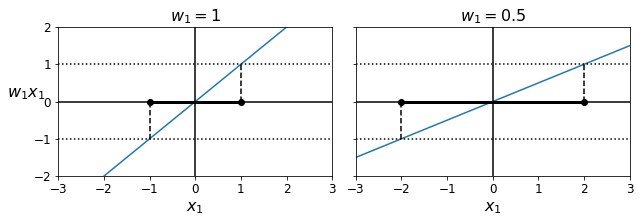

In [30]:
def plot_2D_decision_function(w, b, ylabel=True, x1_lim=[-3, 3]):
    x1 = np.linspace(x1_lim[0], x1_lim[1], 200)
    y = w * x1 + b
    m = 1 / w

    plt.plot(x1, y)
    plt.plot(x1_lim, [1, 1], "k:")
    plt.plot(x1_lim, [-1, -1], "k:")
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.plot([m, m], [0, 1], "k--")
    plt.plot([-m, -m], [0, -1], "k--")
    plt.plot([-m, m], [0, 0], "k-o", linewidth=3)
    plt.axis(x1_lim + [-2, 2])
    plt.xlabel(r"$x_1$", fontsize=16)
    if ylabel:
        plt.ylabel(r"$w_1 x_1$  ", rotation=0, fontsize=16)
    plt.title(r"$w_1 = {}$".format(w), fontsize=16)

fig, axes = plt.subplots(ncols=2, figsize=(9, 3.2), sharey=True)
plt.sca(axes[0])
plot_2D_decision_function(1, 0)
plt.sca(axes[1])
plot_2D_decision_function(0.5, 0, ylabel=False)
save_fig("small_w_large_margin_plot")
plt.show()


# 기울기(가중치)가 1/2작아지면 같은 y==1 까지의 거리가 2배 증가했음. 
# --> 작은 가중치 벡터는 마진을 크게 만든다.

# 연습문제 8 

#### 문제: 선형적으로 분리되는 데이터셋에 LinearSVC를 훈련시켜보세요. 그런 다음 같은 데이터셋에 SVC와SGDClassifier를 적용해보세요. 거의 비슷한 모델이 만들어지는지 확인해보세요.

In [31]:
#SVC는 커널트릭 SGD는 안씀

In [32]:
from sklearn import datasets

iris = datasets.load_iris()

X=iris["data"][:,(2,3)]
y= iris["target"]

setosa_or_versicolor = (y==0)|(y==1)

X= X[setosa_or_versicolor]
y= y [setosa_or_versicolor]

In [35]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

C=5
alpha = 1/(C*len(X)) #정규화 term 

lin_clf = LinearSVC(loss="hinge", C=C, random_state=42)
svm_clf = SVC(kernel = "linear", C=C)
sgd_clf = SGDClassifier(loss="hinge",learning_rate="constant",
                       eta0=0.001, alpha = alpha,
                       max_iter = 1000, tol=1e-3, random_state=42)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lin_clf.fit(X_scaled,y)
svm_clf.fit(X_scaled,y)
sgd_clf.fit(X_scaled,y)


print("LinearSVC:                   ", lin_clf.intercept_, lin_clf.coef_) #bias , weight
print("SVC:                         ", svm_clf.intercept_, svm_clf.coef_)
print("SGDClassifier(alpha={:.5f}):".format(sgd_clf.alpha), sgd_clf.intercept_, sgd_clf.coef_)

LinearSVC:                    [0.28474532] [[1.05364923 1.09903601]]
SVC:                          [0.31896852] [[1.1203284  1.02625193]]
SGDClassifier(alpha=0.00200): [0.117] [[0.77714169 0.72981762]]


In [36]:
lin_clf.coef_

array([[1.05364923, 1.09903601]])

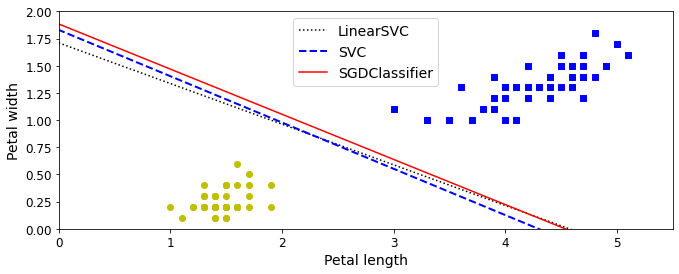

In [38]:
# 각 결정 경계의 기울기와 편향을 계산합니다
w1 = -lin_clf.coef_[0, 0]/lin_clf.coef_[0, 1]
b1 = -lin_clf.intercept_[0]/lin_clf.coef_[0, 1]
w2 = -svm_clf.coef_[0, 0]/svm_clf.coef_[0, 1]
b2 = -svm_clf.intercept_[0]/svm_clf.coef_[0, 1]
w3 = -sgd_clf.coef_[0, 0]/sgd_clf.coef_[0, 1]
b3 = -sgd_clf.intercept_[0]/sgd_clf.coef_[0, 1]

# 결정 경계를 원본 스케일로 변환합니다
line1 = scaler.inverse_transform([[-10, -10 * w1 + b1], [10, 10 * w1 + b1]])
line2 = scaler.inverse_transform([[-10, -10 * w2 + b2], [10, 10 * w2 + b2]])
line3 = scaler.inverse_transform([[-10, -10 * w3 + b3], [10, 10 * w3 + b3]])

plt.figure(figsize=(11,4))
plt.plot(line1[:,0],line1[:,1], "k:", label = "LinearSVC")
plt.plot(line2[:,0],line2[:,1], "b--", linewidth =2 ,label = "SVC")
plt.plot(line3[:,0],line3[:,1], "r-", label = "SGDClassifier")

plt.plot(X[:,0][y==1], X[:,1][y==1],"bs")
plt.plot(X[:,0][y==0], X[:,1][y==0],"yo")

plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper center", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.show()



# 연습문제 9

#### 제: MNIST 데이터셋에 SVM 분류기를 훈련시켜보세요. SVM 분류기는 이진 분류기라서 OvA 전략을 사용해 10개의 숫자를 분류해야 합니다. 처리 속도를 높이기 위해 작은 검증 세트로 하이퍼파라미터를 조정하는 것이 좋습니다. 어느 정도까지 정확도를 높일 수 있나요?

In [39]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)


In [40]:
X= mnist["data"]
y = mnist["target"].astype(np.uint8)


X_train = X[:60000]
y_train = y[:60000]
X_test = X[60000:]
y_test = y[60000:]

#이미 섞여있어서 굳이 다시 안섞음

10000

#### 선형 SVM 분류기부터 시작해보죠. 이 모델은 자동으로 OvA(또는 OvR) 전략을 사용하므로 특별히 처리해 줄 것이 없습니다

In [41]:
lin_clf =LinearSVC(random_state=42)
lin_clf.fit(X_train,y_train)

/opt/anaconda3/envs/env/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

In [42]:
from sklearn.metrics import accuracy_score

y_pred = lin_clf.predict(X_train)
accuracy_score(y_train,y_pred)

0.895

#### MNIST에서 89.5% 정확도면 나쁜 성능입니다. 선형 모델이 MNIST 문제에 너무 단순하기 때문이지만 먼저 데이터의 스케일을 조정할 필요가 있습니다:


In [43]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))
X_test_scaled = scaler.fit_transform(X_test.astype(np.float32))

In [46]:
lin_clf=LinearSVC(random_state=42)
lin_clf.fit(X_train_scaled,y_train)

/opt/anaconda3/envs/env/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

In [49]:
y_pred = lin_clf.predict(X_train_scaled)
accuracy_score(y_train,y_pred)

0.9225333333333333

#### 나아졌지만 아직 부족함. 커널함수를 사용해보자.


In [51]:
svm_clf = SVC(gamma="scale") #svc는 무조건 쌍대문제, 커널이용
svm_clf.fit(X_train_scaled[:10000], y_train[:10000])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [53]:
y_pred = svm_clf.predict(X_train_scaled)
accuracy_score(y_train,y_pred)

#6배 적은 데이터 셋에서 더 좋은 결과를 얻어냄 --> 커널이 좋음

0.9455333333333333

#### 교차 검증을 사용한 랜덤 서치로 하이퍼파라미터 튜닝. (빠른진행을 위해 작은 데이터셋)

In [54]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal,uniform


param_distributions = {"gamma": reciprocal(0.001,0.1),"C":uniform(1,10)}

rnd_search_cv = RandomizedSearchCV(svm_clf,param_distributions, n_iter=10, verbose=2, cv=3)
rnd_search_cv.fit(X_train_scaled[:1000],y_train[:1000])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=5.925176938188639, gamma=0.002457457272781315 .................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .. C=5.925176938188639, gamma=0.002457457272781315, total=   0.6s
[CV] C=5.925176938188639, gamma=0.002457457272781315 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] .. C=5.925176938188639, gamma=0.002457457272781315, total=   0.6s
[CV] C=5.925176938188639, gamma=0.002457457272781315 .................
[CV] .. C=5.925176938188639, gamma=0.002457457272781315, total=   0.6s
[CV] C=8.224521152615054, gamma=0.0036437177217846684 ................
[CV] . C=8.224521152615054, gamma=0.0036437177217846684, total=   0.7s
[CV] C=8.224521152615054, gamma=0.0036437177217846684 ................
[CV] . C=8.224521152615054, gamma=0.0036437177217846684, total=   0.7s
[CV] C=8.224521152615054, gamma=0.0036437177217846684 ................
[CV] . C=8.224521152615054, gamma=0.0036437177217846684, total=   0.7s
[CV] C=1.2431596643145384, gamma=0.01954090133022007 .................
[CV] .. C=1.2431596643145384, gamma=0.01954090133022007, total=   0.7s
[CV] C=1.2431596643145384, gamma=0.01954090133022007 .................
[CV] .. C=1.2431596643145384, gamma=0.01954090133022007, total=   0.7s
[CV] C=1.2431596643145384, gamma=0.01954090133022007 .................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   20.7s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                 class_weight=None, coef0=0.0,
                                 decision_function_shape='ovr', degree=3,
                                 gamma='scale', kernel='rbf', max_iter=-1,
                                 probability=False, random_state=None,
                                 shrinking=True, tol=0.001, verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9185f26d30>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9185f23ca0>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

In [55]:
#짤막팁 . sklearn의 best_estimator_ intercept_ coef_ 와 같은 속성 뒤 _는 훈련된 값이라는 뜻

In [56]:
rnd_search_cv.best_estimator_

SVC(C=4.701587002554444, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=0.0010737748632897968, kernel='rbf', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)

In [58]:
rnd_search_cv.best_score_

#이 점수는 낮지만 1,000개의 샘플만 사용한 것을 기억해야 합니다. 

0.8639957322592053

In [ ]:
#튜닝한 모델에 전체 학습 (오래걸림)
rnd_search_cv.best_estimator_.fit(X_train_scaled, y_train)

In [ ]:
y_pred = rnd_search_cv.best_estimator_.predict(X_train_scaled)
accuracy_score(y_train, y_pred)
#0.9978166666666667



In [60]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
accuracy_score(y_test,y_pred)

0.8816

# 연습문제 10

#### 문제: 캘리포니아 주택 가격 데이터셋에 SVM 회귀를 훈련시켜보세요.

In [65]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
X=housing["data"]
y=housing['target']

#### 세트 나누기

In [66]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test =train_test_split(X,y,test_size=0.2,random_state=42)




#### 스케일 조절

In [84]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)




#### 간단한 LinearSVR 훈련

In [68]:
from sklearn.svm import LinearSVR

lin_svr = LinearSVR(random_state=42)
lin_svr.fit(X_train_scaled,y_train)

/opt/anaconda3/envs/env/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=42, tol=0.0001, verbose=0)

In [69]:
from sklearn.metrics import mean_squared_error

y_pred = lin_svr.predict(X_train_scaled)
mse= mean_squared_error(y_train,y_pred)
mse

0.9545170440733739

In [70]:
#rmse
np.sqrt(mse)

0.976993881287582

#### 훈련 세트에서 타깃은 만달러 단위입니다. RMSE는 기대할 수 있는 에러의 정도를 대략 가늠하게 도와줍니다(에러가 클수록 큰 폭으로 증가합니다). 

rmse가 1정도니깐 이 모델의 에러가 대략 $10,000 정도로 예상할 수 있습니다. 썩 훌륭하지 않네요

#### RBF 커널이 더 나을지 확인해 보겠습니다. 하이퍼파라미터 C와 gamma의 적절한 값을 찾기 위해 교차 검증을 사용한 랜덤 서치를 적용하겠습니다:

In [75]:
from sklearn.svm import SVR

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform


param_distributions = {"gamma": reciprocal(0.001, 0.1),"C":uniform(1,10)}


rnd_search_cv = RandomizedSearchCV(SVR(), param_distributions,n_iter=10,cv=3,verbose=2,random_state=42)

rnd_search_cv.fit(X_train_scaled,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=4.745401188473625, gamma=0.07969454818643928 ..................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ... C=4.745401188473625, gamma=0.07969454818643928, total=   3.2s
[CV] C=4.745401188473625, gamma=0.07969454818643928 ..................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s


[CV] ... C=4.745401188473625, gamma=0.07969454818643928, total=   3.1s
[CV] C=4.745401188473625, gamma=0.07969454818643928 ..................
[CV] ... C=4.745401188473625, gamma=0.07969454818643928, total=   3.2s
[CV] C=8.31993941811405, gamma=0.015751320499779724 ..................
[CV] ... C=8.31993941811405, gamma=0.015751320499779724, total=   2.9s
[CV] C=8.31993941811405, gamma=0.015751320499779724 ..................
[CV] ... C=8.31993941811405, gamma=0.015751320499779724, total=   2.9s
[CV] C=8.31993941811405, gamma=0.015751320499779724 ..................
[CV] ... C=8.31993941811405, gamma=0.015751320499779724, total=   2.9s
[CV] C=2.560186404424365, gamma=0.002051110418843397 .................
[CV] .. C=2.560186404424365, gamma=0.002051110418843397, total=   2.6s
[CV] C=2.560186404424365, gamma=0.002051110418843397 .................
[CV] .. C=2.560186404424365, gamma=0.002051110418843397, total=   2.6s
[CV] C=2.560186404424365, gamma=0.002051110418843397 .................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.4min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9190d35070>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9151c8b970>},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

In [76]:
rnd_search_cv.best_estimator_

SVR(C=4.745401188473625, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma=0.07969454818643928, kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [82]:
y_pred = rnd_search_cv.best_estimator_.predict(X_train_scaled)
mse = mean_squared_error(y_train, y_pred)
np.sqrt(mse)

0.5727524770785359

#### 선형모델보다 커널이 개선됨. 테스트 세트에서 평가

In [85]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
np.sqrt(mse)

1.1066673077043268